In [1]:
import os
import sys
import json
import pathlib
from zipfile import ZipFile

from PIL import Image as pil_image
import pandas as pd
import numpy as np
import cv2
from IPython.display import Image

from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image as keras_image
from keras import layers, models, optimizers, regularizers

print(f"Keras version {keras.__version__}")
print(f"Python version {sys.version}".replace('\n', ''))

INPUT = pathlib.Path('/kaggle/input/aerial-cactus-identification')
TRAIN_DIR = pathlib.Path('train')
TEST_DIR = pathlib.Path('test')

print("\nInput files:")
for dirname, _, filenames in os.walk(INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using TensorFlow backend.


Keras version 2.3.1
Python version 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) [GCC 7.3.0]

Input files:
/kaggle/input/aerial-cactus-identification/test.zip
/kaggle/input/aerial-cactus-identification/train.csv
/kaggle/input/aerial-cactus-identification/train.zip
/kaggle/input/aerial-cactus-identification/sample_submission.csv


Have to unzip everything into the appropriate directories

In [2]:
def maybe_unzip():
    if not TRAIN_DIR.exists():
        TRAIN_DIR.mkdir()
    if not len(os.listdir(TRAIN_DIR)) > 10:
        ZipFile(INPUT / 'train.zip').extractall('.')
    if not TEST_DIR.exists():
        TEST_DIR.mkdir()
    if not len(os.listdir(TEST_DIR)) > 10:
        ZipFile(INPUT / 'test.zip').extractall('.')
maybe_unzip()
print(f"Found {len(list(TRAIN_DIR.glob('*')))} training files in '/{TRAIN_DIR}'")
print(f"Found {len(list(TEST_DIR.glob('*')))} testing files in '/{TEST_DIR}'")

Found 17500 training files in '/train'
Found 4000 testing files in '/test'


Looks like theres only one image size, so that simplifies this.

In [3]:
sizes = set()
for filename in list(TRAIN_DIR.glob('*')) + list(TEST_DIR.glob('*')):
    with pil_image.open(filename) as f:
        sizes.add(f.size)
list(sizes)

[(32, 32)]

In [4]:
train = pd.read_csv(INPUT / 'train.csv')
train.has_cactus = train.has_cactus.astype(str) # Keras throws errors with integers
print(train.shape)
train.head()

(17500, 2)


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


It's a slightly imbalanced dataset, but not nearly as bad as the ieee-fraud-detection challenge

In [5]:
print(train.has_cactus.value_counts())

1    13136
0     4364
Name: has_cactus, dtype: int64


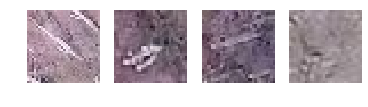

In [6]:
def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image, cmap='Greys_r')
        axis('off')

showImagesHorizontally(list(TRAIN_DIR.glob('*'))[:4])

In [7]:
batch_size = 32
train_datagen = keras_image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.15,
    rescale=1./255,
    preprocessing_function=preprocess_input,  # Make sure we use imagenet normalization since we have a pretrained model
)
test_datagen = keras_image.ImageDataGenerator()

In [8]:
train_batches = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='has_cactus',
    class_mode='binary',
    batch_size=batch_size,
)

Found 17500 validated image filenames belonging to 2 classes.


In [9]:
imgs, labels = next(train_batches)
print(imgs[0].size, imgs[0].shape)

196608 (256, 256, 3)


In [10]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


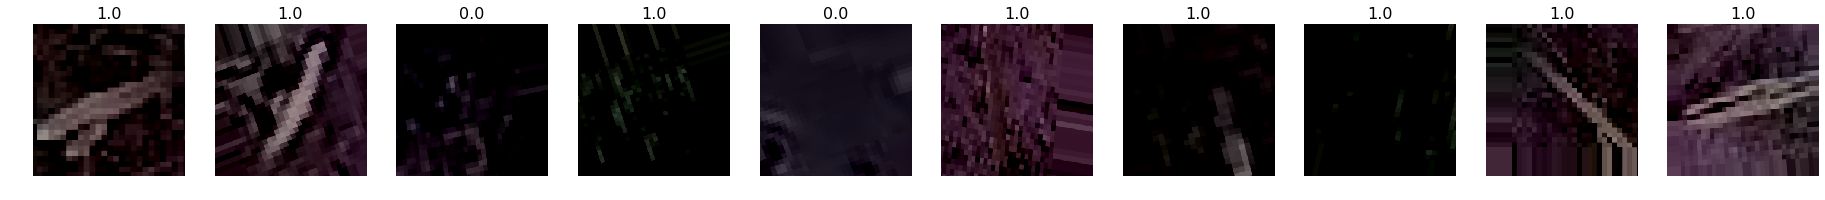

In [11]:
plots(imgs[:10], figsize=(32,32), titles=labels[:10])

In [12]:
vgg16_net = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
vgg16_net.trainable = False
vgg16_net.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [13]:
model = models.Sequential()
model.add(vgg16_net)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 23,103,809
Trainable params: 8,389,121
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=1e-4), 
    metrics=['accuracy', 'binary_accuracy']
)

In [16]:
history = model.fit_generator(
    train_batches,
    epochs=15
)

Epoch 1/15
547/547 [==============================] - 247s 452ms/step - loss: 0.2189 - accuracy: 0.9027 - binary_accuracy: 0.9027
Epoch 2/15
547/547 [==============================] - 246s 449ms/step - loss: 0.1563 - accuracy: 0.9314 - binary_accuracy: 0.9314
Epoch 3/15
547/547 [==============================] - 245s 448ms/step - loss: 0.1393 - accuracy: 0.9399 - binary_accuracy: 0.9399
Epoch 4/15
547/547 [==============================] - 245s 448ms/step - loss: 0.1263 - accuracy: 0.9482 - binary_accuracy: 0.9482
Epoch 5/15
547/547 [==============================] - 245s 448ms/step - loss: 0.1194 - accuracy: 0.9515 - binary_accuracy: 0.9515
Epoch 6/15
547/547 [==============================] - 246s 450ms/step - loss: 0.1126 - accuracy: 0.9555 - binary_accuracy: 0.9555
Epoch 7/15
547/547 [==============================] - 247s 452ms/step - loss: 0.1095 - accuracy: 0.9563 - binary_accuracy: 0.9563
Epoch 8/15
547/547 [==============================] - 246s 449ms/step - loss: 0.1095 - acc

In [17]:
model.save('vgg_pretrained.h5')

In [18]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('history.df')
print(history_df.columns)

Index(['loss', 'accuracy', 'binary_accuracy'], dtype='object')


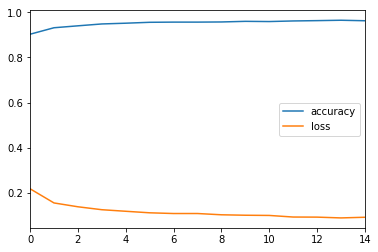

In [19]:
history_df[['accuracy', 'loss']].plot()